<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./263_CAMS_global_forecast_duaod_load_browse.ipynb"><< 263 - CAMS Global Forecast - Dust Aerosol Optical Depth</a><span style="float:right;"><a href="./265_CAMS_European_air_quality_forecast_NO2_load_browse.ipynb">265 - CAMS European air quality forecast - NO2 >></a></span>

<div class="alert alert-block alert-success">
<b>20 - DATA DISCOVERY</b></div>

<hr>

# 2.6.4 CAMS - European Air Quality Forecasts and Analyses - Dust concentration

This notebooks provides an introduction to the CAMS European Air Quality Forecasts and Analyses and how the variable `dust concentration` can be used to monitor dust events.

The notebook examines the **Saharan Dust event** which occured over Europe in the second half of February 2021.

CAMS European Air Quality Forecasts and Analyses are available in either `GRIB` or `netCDF`. You can retrieve the data from the [Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview).

#### Module outline:
* [1 - Load and browse dust aerosol optical depth (AOD) at 550nm of the CAMS global near-real-time forecast](#load_browse_europe)
* [2 - Retrieve the data variable dust AOD at 550nm as xarray.DataArray](#data_retrieve_europ)
* [3 - Visualize dust AOD at 550nm](#visualize_europe)
* [4 - Create a geographical subset for Europe](#subset_europe)
* [5 - Animate dust AOD at 550nm changes over time](#animate_europe)

<hr>

#### Load required libraries

In [1]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from datetime import datetime

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [3]:
%run ../functions.ipynb

<hr>

### <a id='load_browse_europe'></a>Load and browse `CAMS European Air Quality forecast and analyses` data

CAMS global near-real-time forecast data is available either in `GRIB` or `netCDF`. The data for the present example has been downloaded in the `netCDF` format. See an example how to download  

You can use xarray's function `xr.open_dataset()` to open the netCDF file as `xarray.Dataset`. The CAMS global near

In [4]:
file = xr.open_dataset('../eodata/cams/nrt/dust/20210219-24_regional_nrt_dust_concentation.nc')
file


<xarray.Dataset>
Dimensions:    (latitude: 416, level: 1, longitude: 693, time: 28)
Coordinates:
  * longitude  (longitude) float32 335.8 335.9 336.0 336.0 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.55 71.45 71.35 71.25 ... 30.25 30.15 30.05
  * level      (level) float32 1e+03
  * time       (time) timedelta64[ns] 0 days 00:00:00 ... 6 days 18:00:00
Data variables:
    dust       (time, level, latitude, longitude) float32 ...
Attributes:
    title:        Dust Air Pollutant ANALYSIS at 1 levels
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210219-20210225+[0H_18H]
    summary:      ENSEMBLE model hourly ANALYSIS of Dust concentration at 1 l...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

The data above has four dimensions (`latitude`, `longitude`, `level` and `time`) and one data variables:
* `dust`: Dust Air Pollutant

Let us inspect the coordinates of the file more in detail.

Below, you see that the data set consists of 28 time steps, starting on 19 February 2021 00 UTC and ranging up to 6 days ahead. However, the format of the time coordinates is in nanoseconds.

Let us convert the time information into a human-readable time format.

In [5]:
file.time

<xarray.DataArray 'time' (time: 28)>
array([              0,  21600000000000,  43200000000000,  64800000000000,
        86400000000000, 108000000000000, 129600000000000, 151200000000000,
       172800000000000, 194400000000000, 216000000000000, 237600000000000,
       259200000000000, 280800000000000, 302400000000000, 324000000000000,
       345600000000000, 367200000000000, 388800000000000, 410400000000000,
       432000000000000, 453600000000000, 475200000000000, 496800000000000,
       518400000000000, 540000000000000, 561600000000000, 583200000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 0 days 00:00:00 ... 6 days 18:00:00
Attributes:
    long_name:  ANALYSIS time from 20210219

First, from the `long_name` information of the time dimension, we can retrieve the initial timestamp. With the function `strptime()` from Python's `datetime` library, we can convert it into a `datetime.datetime` object.

In [6]:
timestamp = file.time.long_name[19:27]

timestamp_init=datetime.strptime(timestamp,'%Y%m%d' )
timestamp_init

datetime.datetime(2021, 2, 19, 0, 0)

In a next step, we then build a `DateTimeIndex` object with the help of Panda's `date_range()` function, making use of the length of time dimension.

The result is a `DateTimeIndex` object, which can be used to newly assign the time coordinate information.

In [7]:
time_coords = pd.date_range(timestamp_init, periods=len(file.time), freq='6h').strftime("%Y-%m-%d %H:%M:%S").astype('datetime64[ns]')
time_coords


DatetimeIndex(['2021-02-19 00:00:00', '2021-02-19 06:00:00',
               '2021-02-19 12:00:00', '2021-02-19 18:00:00',
               '2021-02-20 00:00:00', '2021-02-20 06:00:00',
               '2021-02-20 12:00:00', '2021-02-20 18:00:00',
               '2021-02-21 00:00:00', '2021-02-21 06:00:00',
               '2021-02-21 12:00:00', '2021-02-21 18:00:00',
               '2021-02-22 00:00:00', '2021-02-22 06:00:00',
               '2021-02-22 12:00:00', '2021-02-22 18:00:00',
               '2021-02-23 00:00:00', '2021-02-23 06:00:00',
               '2021-02-23 12:00:00', '2021-02-23 18:00:00',
               '2021-02-24 00:00:00', '2021-02-24 06:00:00',
               '2021-02-24 12:00:00', '2021-02-24 18:00:00',
               '2021-02-25 00:00:00', '2021-02-25 06:00:00',
               '2021-02-25 12:00:00', '2021-02-25 18:00:00'],
              dtype='datetime64[ns]', freq=None)

<br>

And the last step is to assign the converted time information to the DataArray `dust`, with the function `assign_coords()`.

In [8]:
dust = file.assign_coords(time=time_coords)
dust

<xarray.Dataset>
Dimensions:    (latitude: 416, level: 1, longitude: 693, time: 28)
Coordinates:
  * longitude  (longitude) float32 335.8 335.9 336.0 336.0 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.55 71.45 71.35 71.25 ... 30.25 30.15 30.05
  * level      (level) float32 1e+03
  * time       (time) datetime64[ns] 2021-02-19 ... 2021-02-25T18:00:00
Data variables:
    dust       (time, level, latitude, longitude) float32 ...
Attributes:
    title:        Dust Air Pollutant ANALYSIS at 1 levels
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210219-20210225+[0H_18H]
    summary:      ENSEMBLE model hourly ANALYSIS of Dust concentration at 1 l...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

The latitude values have a 0.1 degrees resolution and have a global N-S coverage.

In [9]:
file.latitude

<xarray.DataArray 'latitude' (latitude: 416)>
array([71.55, 71.45, 71.35, ..., 30.25, 30.15, 30.05], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 71.55 71.45 71.35 71.25 ... 30.25 30.15 30.05
Attributes:
    long_name:  latitude
    units:      degrees_north

The longitude values have a 0.1 degrees resolution as well, but are on a [0,360] grid instead of a [-180,180] grid. 

In [10]:
file.longitude

<xarray.DataArray 'longitude' (longitude: 693)>
array([335.75, 335.85, 335.95, ...,  44.75,  44.85,  44.95], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 335.8 335.9 336.0 336.0 ... 44.75 44.85 44.95
Attributes:
    long_name:  longitude
    units:      degrees_east

<br>

### <a id='shift_europe'></a>Bring longitude coordinates onto a [-180,180] grid

You can assign new values to coordinates in an `xarray.Dataset`. You can do so with the `assign_coords()` function, which you can apply onto a `xarray.Dataset`. With the code below, you shift your longitude grid from [0,360] to [-180,180]. At the end, you sort the longitude values in an ascending order.

In [11]:
file_assigned = dust.assign_coords(longitude=(((dust.longitude + 180) % 360) - 180)).sortby('longitude')
file_assigned

<xarray.Dataset>
Dimensions:    (latitude: 416, level: 1, longitude: 693, time: 28)
Coordinates:
  * longitude  (longitude) float32 -24.25 -24.15 -24.05 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.55 71.45 71.35 71.25 ... 30.25 30.15 30.05
  * level      (level) float32 1e+03
  * time       (time) datetime64[ns] 2021-02-19 ... 2021-02-25T18:00:00
Data variables:
    dust       (time, level, latitude, longitude) float32 ...
Attributes:
    title:        Dust Air Pollutant ANALYSIS at 1 levels
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210219-20210225+[0H_18H]
    summary:      ENSEMBLE model hourly ANALYSIS of Dust concentration at 1 l...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

A quick check of the longitude coordinates of the new `xarray.Dataset` shows you that the longitude values range now between [-180, 180].

In [12]:
file_assigned.longitude

<xarray.DataArray 'longitude' (longitude: 693)>
array([-24.25    , -24.150024, -24.049988, ...,  44.75    ,  44.850006,
        44.949997], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -24.25 -24.15 -24.05 ... 44.75 44.85 44.95

### <a id='data_retrieve_europe'></a>Retrieve the data variable `dust` as xarray.DataArray

Let us store the data variable `dust concentration` as `xarray.DataArray` with the name `dust`.

In [13]:
dust = file_assigned.dust
dust

<xarray.DataArray 'dust' (time: 28, level: 1, latitude: 416, longitude: 693)>
[8072064 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -24.25 -24.15 -24.05 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.55 71.45 71.35 71.25 ... 30.25 30.15 30.05
  * level      (level) float32 1e+03
  * time       (time) datetime64[ns] 2021-02-19 ... 2021-02-25T18:00:00
Attributes:
    species:        Dust
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_dust_in_air

<br>

Above, you see that the variable `dust` has four attributes, `species`, `units`, `value` and `standard_name`. Let us define variables for `unit` and `standard_name` attributes. The variables can be used for visualizing the data.

In [14]:
long_name = dust.standard_name
units = dust.units

<br>

Let us do the same for the coordinates `longitude` and `latitude`.

In [15]:
latitude = dust.latitude
longitude = dust.longitude

<br>

### <a id='visualize_europe'></a>Visualize `dust` concentration

The next step is to visualize the dataset. You can use the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh), which makes use of matploblib's function `pcolormesh` and the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.

With `?visualize_pcolormesh` you can open the function's docstring to see what keyword arguments are needed to prepare your plot.

In [12]:
?visualize_pcolormesh

<br>

You can make use of the variables we have defined above:
- `units`
- `long_name`
- `latitude`
- `longitude`

Additionally, you can specify the color scale and minimum and maxium data values.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'mass_concentration_of_dust_in_air 2021-02-24T00:00:00.000000000'}>)

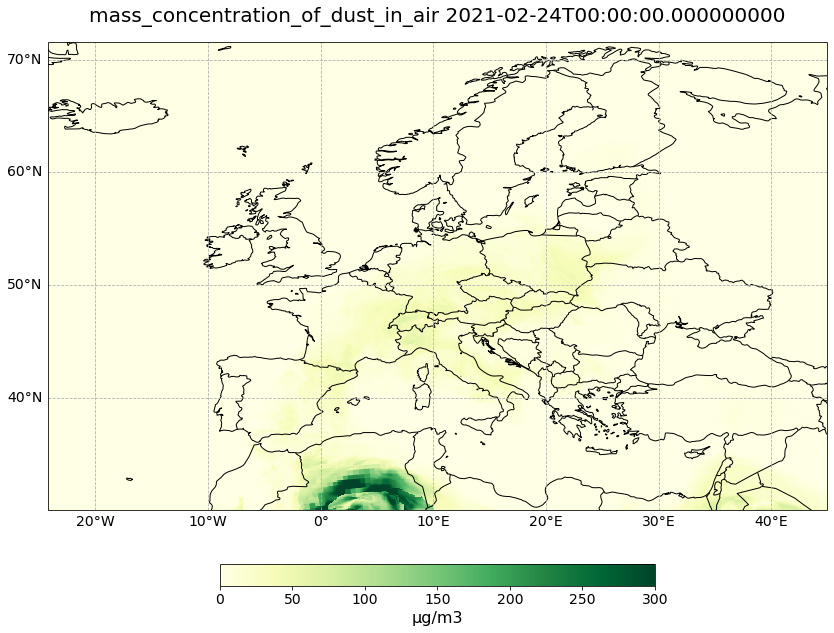

In [16]:
visualize_pcolormesh(data_array=dust[20,0,:,:],
                     longitude=longitude,
                     latitude=latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='YlGn',
                     unit=units,
                     long_name=long_name + ' ' + str(dust[20,0,:,:].time.data),
                     vmin=0, 
                     vmax=300,
                     lonmin=longitude.min().data,
                     lonmax=longitude.max().data,
                     latmin=latitude.min().data,
                     latmax=latitude.max().data,
                     set_global=False)

<br>

### <a id='animate_europe'></a>Animate `dust concentration` analyses over Europe

In the last step, you can animate the `organic matter AOD at 550nm` in order to see how the trace gas develops over a period of seven days, from 25th to 31st December 2019.

You can do animations with matplotlib's function `animation`. Jupyter's function `HTML` can then be used to display HTML and video content.

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [17]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=dust[0,0,:,:],
                               longitude=dust.longitude, 
                               latitude=dust.latitude,
                               projection=ccrs.PlateCarree(), 
                               color_scale='YlGn', 
                               unit=units,
                               long_name=long_name + ' '+ str(dust.time[0].data),
                               vmin=0,
                               vmax=250, 
                               lonmin=longitude.min().data, 
                               lonmax=longitude.max().data, 
                               latmin=latitude.min().data, 
                               latmax=latitude.max().data,
                               set_global=False)

frames = 28

def draw(i):
    img = plt.pcolormesh(dust.longitude, 
                         dust.latitude, 
                         dust[i,0,:,:], 
                         cmap='YlGn', 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=250,
                         shading='auto')
    
    ax.set_title(long_name + ' '+ str(dust.time[i].data), fontsize=20, pad=20.0)
    return img


def init():
    return fig


def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())
plt.close(fig)

<br>

#### Play the animation video as HTML5 video

In [18]:
HTML(ani.to_html5_video())

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./263_CAMS_global_forecast_duaod_load_browse.ipynb"><< 263 - CAMS Global Forecast - Dust Aerosol Optical Depth</a><span style="float:right;"><a href="./265_CAMS_European_air_quality_forecast_NO2_load_browse.ipynb">265 - CAMS European air quality forecast - NO2 >></a></span>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>